









.# End-to-end multiclass Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.0 and Tensorflow Hub.

## 1. Problem 
Identify the breed of a dog given an image of a dog.

when I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data we're using is from Kaggle dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with predictions probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning / transfer learning.

* There are 120 breeds of dogs (this means there are 120 different classes). 

* There are around 10,000+ images in the training set.
(these images have labels)
* There are around 10,000+ images in the test set.
(these images have no labels, because we'll want to predict them)



In [0]:
# Unzip the uploaded data into Google Drive
# !unzip "/content/drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "drive/My Drive/Dog Vision/"

### Get our workspace ready

* Import TensorFlow 2.x 
* Import TensorFlow Hub
* Make sure we're using a GPU

### Get our workspace ready

In [5]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

print("TF version: ", tf.__version__)
print("TF Hub verson", hub.__version__)

#  Check for GPU availability
print("GPU", "available (YESSSSS!!!!)" if tf.config.list_physical_devices("GPU") else "not available:(")


TF version:  2.2.0-rc3
TF Hub verson 0.8.0
GPU available (YESSSSS!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. so that's what we'll be doing first. Turning our images into Tensors(numerical representations).

Let's start by accessing our data and checking out the labels.

In [6]:
# Check the labels of our data
import pandas as pd
import numpy as np
label_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(label_csv.describe())
print(label_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     53c2a1da882f6cf57b3843a8a12dd677  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


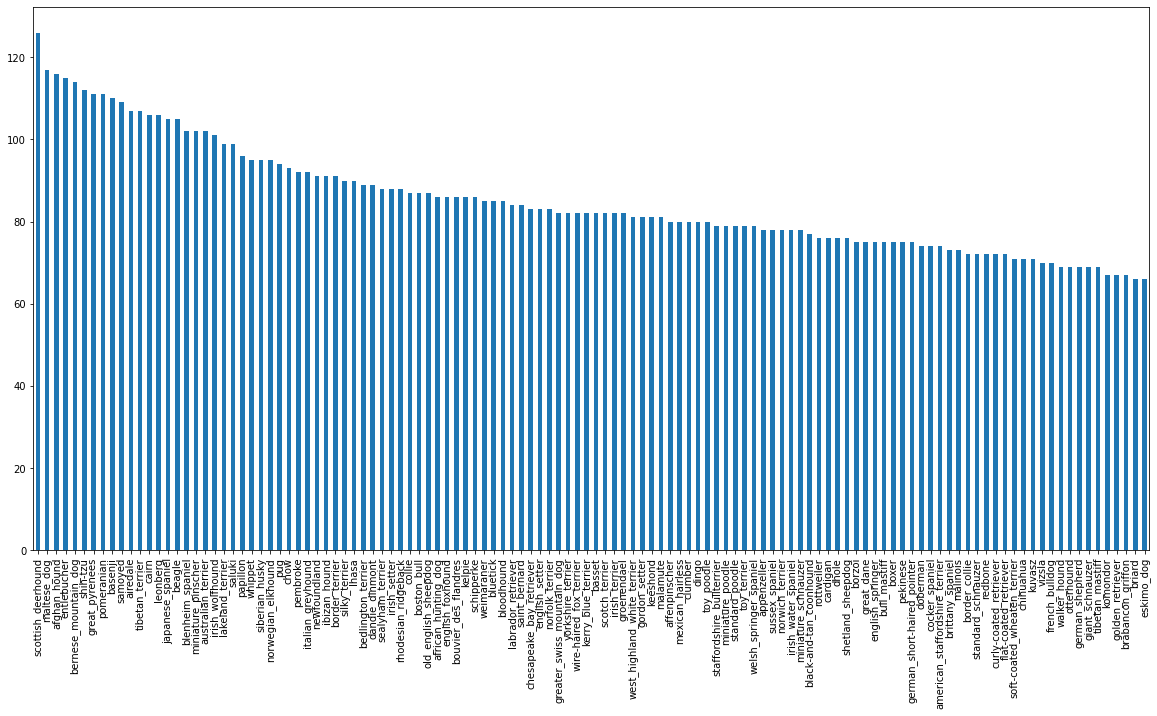

In [8]:
# How many images are there of each breed?
label_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [143]:
label_csv["breed"].value_counts().median()

82.0

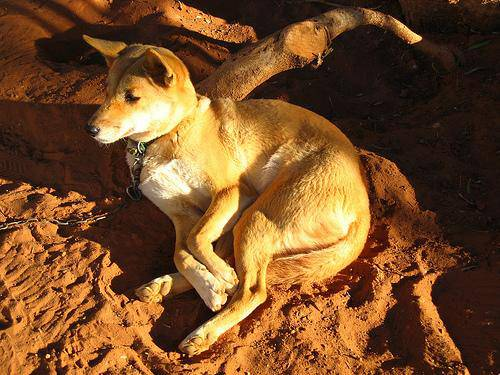

In [9]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

## Getting images and their labels

Let's get a list of all of our image file pathnames.

In [27]:
label_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [28]:
## create pathnames from image ID's
filenames = ["drive/My Drive/Dog Vision/train/" +fname+".jpg" for fname in label_csv["id"]]

## check the first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [29]:
# check whether number of filenames matches number of actual image files.
import os
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed")
else:
  print("Filenames do not match actual amount of files, check the target directory")


Filenames match actual amount of files!!! Proceed


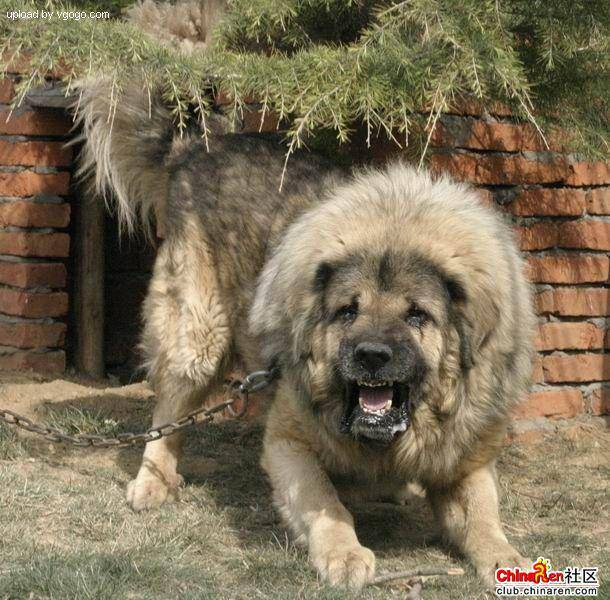

In [30]:
# one more check
Image(filenames[9000])

In [31]:
label_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list,
let's prepare our labels.

In [32]:
import numpy as np
labels = label_csv["breed"].to_numpy()
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [33]:
len(labels)

10222

In [34]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames.")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames.


In [35]:
# Find the unique label values 
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [36]:
# Turn a single label into an array of boolean 
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [37]:
len(labels)

10222

In [38]:

# Turn Every Label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [39]:
print(len(boolean_labels))
len(unique_breeds)

10222


120

In [40]:
# Example: Turning boolean array into integers
print(labels[0]) #  origin label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) #  there will be a 1 where the sample labels occurs 

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [41]:
 print(labels[2])
 print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [42]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own validation set
Since the dataset from kaggle doesn't come with a validation set, we're going to create our own.

In [0]:

# Setup X and y variables
X = filenames
y = boolean_labels


In [47]:
len(X), len(y)

(10222, 10222)

We're going to start off experimenting with ~1000 images and
increase as needed.

In [0]:
# Set number of images to use for experimenting 
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [49]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size = 0.2,
                                                  random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [50]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing Images(Turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image file path as input 
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors.
4. Normalize our image (Convert color channel values from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`.


Before we do, let's see what importing an image looks like.

In [51]:
# Convert an image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape # Height, Width, Color_Channel

(257, 350, 3)

In [52]:
image.max(), image.min() #RGB pixel values between 0 to 255

(255, 0)

In [53]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [54]:
# Turn image into tensor
tf.constant(image)[:2] # These is same as above but it loaded in GPU. so it is more faster.

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

1. Take an image file path as input 
2. Use Tensorflow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors.
4. Normalize our image (Convert color channel values from 0-255 to 0-1)
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`.

In [0]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file 
  image = tf.io.read_file(image_path)

  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [56]:
tensor = tf.io.read_file(filenames[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [57]:
tensor = tf.image.decode_jpeg(tensor, channels=3)
tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(500, 375, 3), dtype=float32, numpy=
array([[[0.23137257, 0.26666668, 0.25490198],
        [0.2509804 , 0.28627452, 0.27450982],
        [0.2784314 , 0.3137255 , 0.3019608 ],
        ...,
        [0.45098042, 0.5019608 , 0.42352945],
        [0.45098042, 0.5019608 , 0.42352945],
        [0.43137258, 0.48235297, 0.4039216 ]],

       [[0.25490198, 0.2901961 , 0.2784314 ],
        [0.28235295, 0.31764707, 0.30588236],
        [0.30980393, 0.34509805, 0.33333334],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.45882356, 0.50980395, 0.43137258],
        [0.454902  , 0.5058824 , 0.427451  ]],

       [[0.26666668, 0.3019608 , 0.2901961 ],
        [0.29803923, 0.33333334, 0.32156864],
        [0.3254902 , 0.36078432, 0.34901962],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.47058827, 0.52156866, 0.4431373 ],
        [0.48235297, 0.53333336, 0.454902  ]],

       ...,

       [[0.6784314 , 0.7843138 , 0.60784316],
        [0.64

## Turning our data into batches
Tips: google- yann lecun batch size

Why turn our  data into batches?

Let's you're trying to process 10,000+ images in one go... they all might not fit into memory

So that's why we do about 32 (this is batch size) images at a time (you can manually adjust batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this:
`(image, label)`.

In [0]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label



In [59]:
# Demo of the above
(process_image(X[42]) ,tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [0]:
# Define  the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches (Here y is None because y is label and does not required for testing data)
def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label(y).
  Shuffles data  if it's training data but doesn't shuffles if it's validation data.
  Also accepts test data as input (no labels).
  """ 

  # If the data is a test dataset, we probably don't have labels.
  if test_data:
    print("Creating test data batches.....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE) # It creates batches into 32 and label is not required so used process_image()
    return data_batch

  # If the data is valid dataset, we don't need to shuffle it 
  elif valid_data:
    print("Creating a validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
      print("Creating training data batches...")
      # Turn filepaths and labels into Tensors
      data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                 tf.constant(y)))
      # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
      data = data.shuffle(buffer_size = len(X))

      # Create (image, label) tuples (this also turns the image path into a preprocessed image)
      data = data.map(get_image_label)

      # Turn the training data into batches
      data_batch = data.batch(BATCH_SIZE)
    
  return data_batch


In [61]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)


Creating training data batches...
Creating a validation data batches...


In [62]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec
# Here we get in output shape=(batch_size, height, width, color channel)
# Note: here batch_size may be varies so it's None

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a Little hard to understand/comprehend, let's visualize them!

In [0]:
import matplotlib.pyplot as plt

#Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """

  # Setup the figure
  plt.figure(figsize = (10, 10))

  #Loop through 25(for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image labels as title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

In [64]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

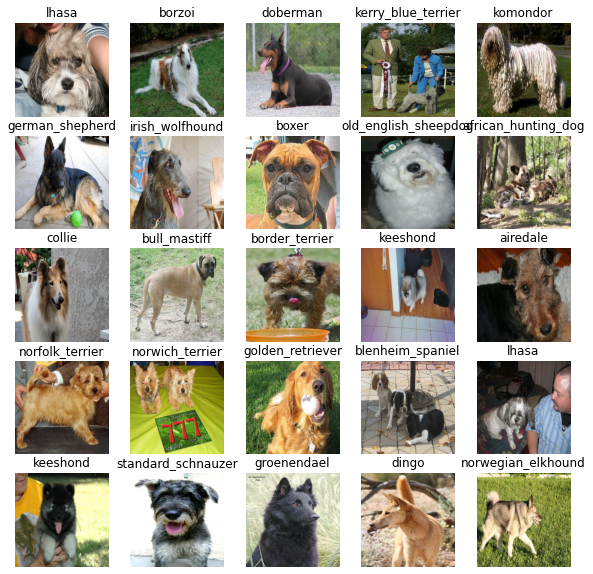

In [65]:
# Now let's visualize the data in a training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

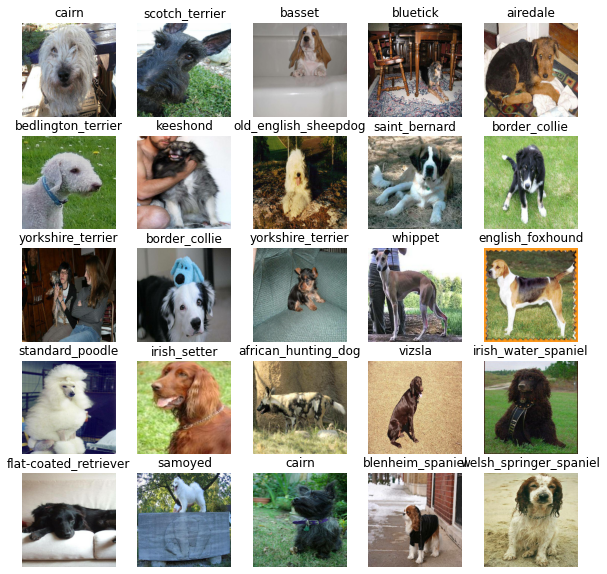

In [66]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)


## Building a model

Before we build a model, there are few things we need to define:
* The input shape(our image shape, in the form of Tensors) to our model.
* The output shape(image labels, in the form of Tensors ) of our model.
* The URL of the model we want to use from TensorFlow Hub:-
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

Tips:
Some websites are given below--
1. https://pytorch.org/hub/
2. https://www.tensorflow.org/hub
3. https://modelzoo.co/
4. https://paperswithcode.com/ 
5. https://towardsdatascience.com/review-mobilenetv2-light-weight-model-image-classification-8febb490e61c


Note: Complete Machine Learning and Data Science: Zero to Mastery Udemy Video 222 is very important for how to build deep learning model (IMP)

Note: In Tensorhub the higher the number better the model but it also takes more time to train model.

In [86]:
IMG_SIZE

224

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channel

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"



In [88]:
INPUT_SHAPE

[None, 224, 224, 3]

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've
choosen as parameters.

* Defines the layers in a Keras model in a sequential fashion
(do this first, then this, then that).

* Compiles the model (says it should be evaluated and improved).

* Builds the model (tells the model the input shape it'll be getting).

* Returns the model.

All these steps can be found here:https://www.tensorflow.org/guide/keras/overview


In [0]:
# Create a function which builds a keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (the input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                           activation = "softmax") #Layer 2 (the output layer)
  ])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

# Video-224 told us about function and all these things.

In [90]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating a callbacks

Callbacks are helpful functions a model can use during training to do such things as saves its progress, check its progress or stop training early if model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension
2. Create a TensorBoard callback which is able to save logs to a directory and pass it's to our model's `fit()` fuction.
3. Visualize our models training logs with the `tensorboard` magic function (we'll do this after model training).

In [91]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
 import datetime

 # Create a function to build a TensorBoard callback
 def create_tensorboard_callback():
   # Create a log directory for storing TensorBoard logs (manually create in Dog Vision file as log file)
   logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                         # Make it so the logs get tracked whenever we run an experiment
                         datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
   return tf.keras.callbacks.TensorBoard(logdir)


### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metrics stop improving. 


https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping



In [0]:
# Create Early stopping callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model(on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [95]:
# Check to make sure we're still running on a GPU
print("GPU", "availabe(yesss!!!)" if tf.config.list_physical_devices("GPU") else "not available: (GPU)")

GPU availabe(yesss!!!)


Let's create a function which trains a model.

* create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (`NUM_EPOCHS`) and the callbacks we'd like to use.
* Return the model 

In [0]:
# Build a function to train and return a trained model
def train_model():
  """
  Train a given model and returns the trained version.
  """

  # Create a model
  model = create_model()

  # Create a TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fits the model to the data passing it the callbacks we created 
  model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data = val_data,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [56]:
# Fit the model to the data
model = train_model()

# If our model learns then loss go down and accuracy go up

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 481s 19s/step - loss: 4.5318 - accuracy: 0.0962 - val_loss: 3.4915 - val_accuracy: 0.1950
Epoch 2/100
25/25 [==============================] - 6s 249ms/step - loss: 1.6154 - accuracy: 0.6612 - val_loss: 2.2423 - val_accuracy: 0.4300
Epoch 3/100
25/25 [==============================] - 6s 243ms/step - loss: 0.5747 - accuracy: 0.9250 - val_loss: 1.7171 - val_accuracy: 0.5750
Epoch 4/100
25/25 [==============================] - 6s 225ms/step - loss: 0.2623 - accuracy: 0.9787 - val_loss: 1.5361 - val_accuracy: 0.6000
Epoch 5/100
25/25 [==============================] - 6s 226ms/step - loss: 0.1535 - accuracy: 0.9975 - val_loss: 1.4471 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 6s 225ms/step - loss: 0.1035 - accuracy: 0.9975 - val_loss: 1.4029 - val_accuracy: 0.6200
Epoch 7/100
25/25 [==============================

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural network?

**Note:** Overfitting to begin with is good thing! It means our model is learning!!!



### Checking the TensorBoard logs

The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its 

In [16]:
%tensorboard --logdir drive/My\ Drive/Dog\ Vision/logs # whenever there is space I use backslash and space

Output hidden; open in https://colab.research.google.com to view.

## Making and Evaluating predictions using a trained model

In [85]:
# Make predictions on validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

NameError: ignored

In [59]:
predictions[0] #It gives probability of each image compared to 120 and get highest probability.(These for one image)

array([5.02923096e-04, 2.65318231e-05, 1.19558931e-03, 2.69629290e-05,
       1.82160671e-04, 6.07173797e-06, 2.40168478e-02, 1.09531538e-04,
       8.02915019e-05, 5.72766643e-04, 1.00089761e-04, 9.63498751e-05,
       1.99655682e-04, 1.11540801e-04, 3.51908617e-04, 2.43939532e-04,
       1.11623915e-04, 4.56764624e-02, 1.25105571e-05, 1.91571035e-05,
       2.10443890e-04, 1.38072239e-04, 1.94417571e-05, 8.41229048e-04,
       2.53646194e-05, 2.29010751e-04, 4.62306857e-01, 5.79165717e-05,
       3.06744099e-04, 6.84223924e-05, 1.23973412e-04, 8.72332253e-04,
       1.57594433e-04, 3.98495322e-05, 2.34657098e-04, 3.88123803e-02,
       7.56865302e-06, 2.41026515e-04, 4.48224164e-05, 1.47430153e-04,
       5.50234225e-03, 9.08641232e-06, 1.83198819e-04, 2.24749565e-05,
       5.38332642e-06, 1.42105040e-04, 2.40299050e-05, 3.62285791e-05,
       9.37812365e-05, 1.84230143e-04, 8.57232779e-04, 9.46111104e-05,
       1.25867839e-04, 2.06587487e-04, 1.97134301e-04, 2.54671613e-04,
      

In [60]:
np.sum(predictions[0]) # It will gives sum very close to 1

0.99999994

In [61]:
np.sum(predictions[1])

1.0000001

In [62]:
predictions.shape

(200, 120)

In [63]:
len(y_val)

200

In [64]:
len(unique_breeds)

120

In [84]:
# First prediction
index = 42
print(predictions[0])
print(f"Max value (probability of predictions): {np.max(predictions[0])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max Index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")


NameError: ignored

In [66]:
unique_breeds[113]

'walker_hound'

Having the abbove functionality is great but we want to be able to do it at scale.
And it would be even better if we could see the image the prediction is being made on.

**Note:-** Predictions probabilities are also known as confidence level.



In [97]:
# turn prediction probabilies into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

NameError: ignored

Now since, our validation data is still in a batch dataset,we'll have to unbatchify it to make predictions on the validation images and then compare those prredictions to the validations labels (truth labels).

In [68]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of images and labels.
  """

  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

Now we've got ways to get:
* Predictions labels
* Validation labels(truth labels)
* Validation Images

Let's make some function to make these all a bit more visualize.

We'll create a function which:
* Takes an array of predictions probabilities, an array of truth lables and an array of images and an integer.
* Convert the predictions probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and the target image on single plot.

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n 
  """
  pred_prob, true_label, image= prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  # Change plot title to be predicted, probability of prediction and truth
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color = color)
  

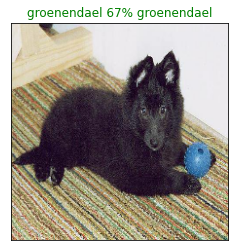

In [70]:
plot_pred(prediction_probabilities = predictions,
          labels = val_labels,
          images = val_images,
          n = 77)

Now we've got one function to visualize our model prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer.
* Find the prediction using `get_pred_label()`
* Find the top 10:
  * Prediction probabilities indexes
  * Prediction probabilities values
  * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green  

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = "grey"
                     )
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = "vertical")
  
  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


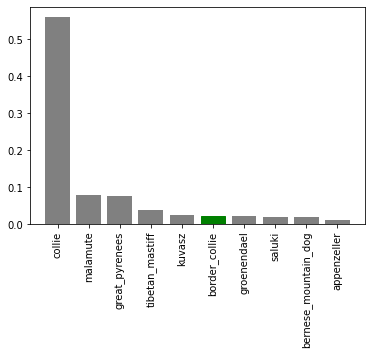

In [72]:
plot_pred_conf(prediction_probabilities=predictions,
               labels = val_labels,
               n=9)

In [73]:
# These second square bracket gives top 10 predictions of at indexes in descending order.
predictions[0][predictions[0].argsort()[-10:][::-1]] 

array([0.46230686, 0.1271019 , 0.05466255, 0.04567646, 0.04292741,
       0.03881238, 0.03615052, 0.02790645, 0.02401685, 0.01884518],
      dtype=float32)

In [74]:
predictions[0].max()

0.46230686

In [75]:
# Top 10 predictions labels 
unique_breeds[predictions[0].argsort()[-10:][::-1]]

array(['cairn', 'irish_wolfhound', 'soft-coated_wheaten_terrier',
       'border_terrier', 'standard_schnauzer', 'dandie_dinmont', 'lhasa',
       'silky_terrier', 'australian_terrier', 'shih-tzu'], dtype=object)

Now we've got some function to help us visualize our predictions and evaluate our model, let's check out a few.

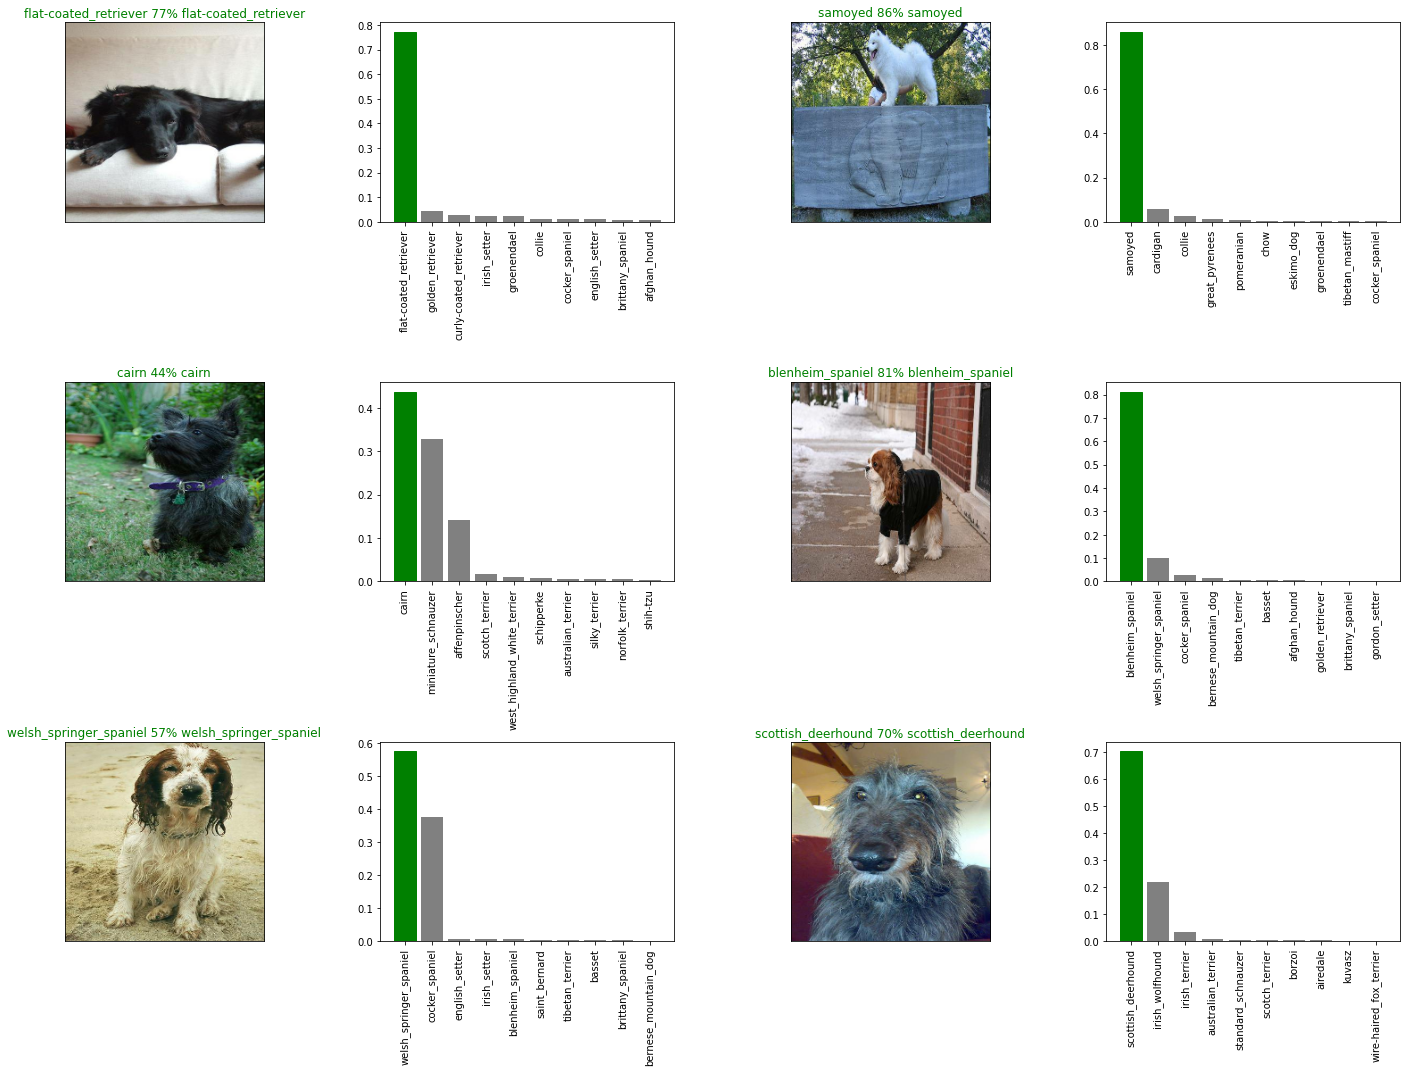

In [84]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize = (10*num_cols, 5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities = predictions,
            labels = val_labels,
            images = val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities = predictions,
                 labels = val_labels,
                 n = i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true labels? 

## Saving and Reloading our trained model 

In [0]:
# Create a function to save a model 
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string)
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir+"-"+suffix+".h5" #save format of model
  print(f"Saving model to:{model_path}...")
  model.save(model_path)
  return model_path 


In [0]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specific path.
  """
  print(f"Loading a saved models from:{model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model,
let's make sure they work!

In [89]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to:drive/My Drive/Dog Vision/models/20200418-08431587199434-1000-images-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200418-08431587199434-1000-images-mobilenetv2-Adam.h5'

In [94]:
# Load a trained model
loaded_1000_image_model =  load_model("drive/My Drive/Dog Vision/models/20200418-08431587199434-1000-images-mobilenetv2-Adam.h5")

Loading a saved models from:drive/My Drive/Dog Vision/models/20200418-08431587199434-1000-images-mobilenetv2-Adam.h5


In [95]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 1s 131ms/step - loss: 1.2453 - accuracy: 0.6750


[1.245298981666565, 0.675000011920929]

In [96]:
# Evaluate a loaded model
loaded_1000_image_model.evaluate(val_data) 

7/7 [==============================] - 1s 141ms/step - loss: 1.2453 - accuracy: 0.6750


[1.245298981666565, 0.675000011920929]

## Training a big dog model (on the full data)

In [98]:
len(X), len(y), len(X_train), len(y_train)

(10222, 10222, 800, 800)

In [99]:
# Create a data batch with full dataset
full_data = create_data_batches(X, y)

Creating training data batches...


In [100]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [101]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()

#No validation set when training all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)


**Note:** Running a cell below will take a little while (maybe upto 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all of the images into memory.

In [103]:
# Fit the full model to the full data
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 4863s 15s/step - loss: 1.3425 - accuracy: 0.6699
Epoch 2/100
320/320 [==============================] - 66s 207ms/step - loss: 0.3996 - accuracy: 0.8794
Epoch 3/100
320/320 [==============================] - 66s 206ms/step - loss: 0.2364 - accuracy: 0.9349
Epoch 4/100
320/320 [==============================] - 66s 205ms/step - loss: 0.1541 - accuracy: 0.9630
Epoch 5/100
320/320 [==============================] - 67s 211ms/step - loss: 0.1069 - accuracy: 0.9773
Epoch 6/100
320/320 [==============================] - 65s 204ms/step - loss: 0.0770 - accuracy: 0.9870
Epoch 7/100
320/320 [==============================] - 65s 203ms/step - loss: 0.0587 - accuracy: 0.9917
Epoch 8/100
320/320 [==============================] - 65s 203ms/step - loss: 0.0463 - accuracy: 0.9939
Epoch 9/100
320/320 [==============================] - 65s 204ms/step - loss: 0.0369 - accuracy: 0.9963
Epoch 10/100
320/320 [==============================] - 66s 205m

In [104]:
save_model(full_model, suffix="full-image-set-mobilenetv2-Adam")

Saving model to:drive/My Drive/Dog Vision/models/20200418-11281587209339-full-image-set-mobilenetv2-Adam.h5...


'drive/My Drive/Dog Vision/models/20200418-11281587209339-full-image-set-mobilenetv2-Adam.h5'

In [76]:
# Load in the full model
loaded_full_model = load_model("drive/My Drive/Dog Vision/models/20200418-11281587209339-full-image-set-mobilenetv2-Adam.h5")

Loading a saved models from:drive/My Drive/Dog Vision/models/20200418-11281587209339-full-image-set-mobilenetv2-Adam.h5


## Making predictions on test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and convert them into tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames 
* Convert the filenames into test data batches using `create_data_batches` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).
* Make a prediction array by passing the test batches to the `predict()` method called on our model.

In [146]:
# Load test image files
test_path = "/content/drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/My Drive/Dog Vision/test/f21691cb46f6d593ec77a7a0000c4454.jpg',
 '/content/drive/My Drive/Dog Vision/test/f569c5b12fae4ca37d376d21bc05f2b3.jpg',
 '/content/drive/My Drive/Dog Vision/test/f4f77d0d3e23e06fe2c1941edf919eb3.jpg',
 '/content/drive/My Drive/Dog Vision/test/f1167eabf53759dad015f0abb813a451.jpg',
 '/content/drive/My Drive/Dog Vision/test/f0311d1414f9ce10cffda4c207c108dc.jpg',
 '/content/drive/My Drive/Dog Vision/test/e917abf625ad6ba5b8a0e59bd23e8818.jpg',
 '/content/drive/My Drive/Dog Vision/test/ea1e945b924638c2059d7718b522d48f.jpg',
 '/content/drive/My Drive/Dog Vision/test/e9f25d81c8fa96020a77a1f3148d0d3c.jpg',
 '/content/drive/My Drive/Dog Vision/test/eac3503b463e275d9f3053b8fcd5a58a.jpg',
 '/content/drive/My Drive/Dog Vision/test/f3e898913d681b7d938a298f9e068254.jpg']

In [147]:
len(test_filenames)

10357

In [148]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches.....


In [149]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take long time to run(about an `1hr).

In [18]:
# Make prediction on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data, verbose=1)

NameError: ignored

In [0]:
# Save Prediction (Numpy array) to csv file (for access later)
np.savetxt("drive/My Drive/Dog Vision/preds_array.csv",test_predictions, delimiter=",")

In [0]:
# Load predictions (Numpy array) from csv file
test_predictions = np.loadtxt("drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [20]:
test_predictions[:10]

array([[4.03087329e-12, 1.17012053e-10, 6.30202904e-11, ...,
        3.13402381e-07, 2.55250066e-09, 3.13869833e-11],
       [2.42941974e-06, 2.43703752e-10, 1.53066093e-09, ...,
        4.30309626e-07, 3.08888701e-07, 1.09828090e-06],
       [1.19812005e-09, 1.13109294e-07, 6.60986856e-08, ...,
        1.45065712e-06, 1.35863957e-06, 2.99389090e-11],
       ...,
       [9.56642099e-10, 4.37115766e-09, 2.64158029e-09, ...,
        1.37479930e-07, 8.97187591e-01, 5.06453475e-08],
       [1.55403313e-07, 6.89514200e-05, 1.08779536e-08, ...,
        6.75166802e-07, 4.86987728e-10, 1.45989446e-07],
       [1.40254879e-16, 5.69495826e-14, 4.13544228e-15, ...,
        1.36871634e-12, 2.56243892e-13, 1.78941830e-15]])

In [21]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for kaggle 

Looking at the kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFrame with an ID and a column for each different dog breed.https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed 
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data(the predictions probabilities) to each of the dog breed columns
* Export the DataFrame as a CSV to submit it to kaggle.
 

In [72]:
# Create a pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns= ["id"] + list(unique_breeds))
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [0]:
# append test image ID's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [167]:
preds_df.head()

id  ... yorkshire_terrier
0  f21691cb46f6d593ec77a7a0000c4454  ...               NaN
1  f569c5b12fae4ca37d376d21bc05f2b3  ...               NaN
2  f4f77d0d3e23e06fe2c1941edf919eb3  ...               NaN
3  f1167eabf53759dad015f0abb813a451  ...               NaN
4  f0311d1414f9ce10cffda4c207c108dc  ...               NaN

[5 rows x 121 columns]

In [169]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  f21691cb46f6d593ec77a7a0000c4454  ...        3.1387e-11
1  f569c5b12fae4ca37d376d21bc05f2b3  ...       1.09828e-06
2  f4f77d0d3e23e06fe2c1941edf919eb3  ...       2.99389e-11
3  f1167eabf53759dad015f0abb813a451  ...       3.73551e-12
4  f0311d1414f9ce10cffda4c207c108dc  ...       0.000220832

[5 rows x 121 columns]

In [0]:
# Save our predictions dataframe to CSV for submission to kaggle
preds_df.to_csv("drive/My Drive/Dog Vision/full_model_prediction_submission_1_mobilenetV2.csv",
                index=False)

# Making predictions on custom images 

To make images on custom images, we'll:
* Get the filepaths of our own images.
* Turn the file paths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model `predict()` method. 
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [0]:
# Get Custom image filepaths
import os
custom_path = "drive/My Drive/Dog Vision/my-dog-photos/"
custom_image_paths =  [custom_path + fname for fname in os.listdir(custom_path)]


In [26]:
custom_image_paths

['drive/My Drive/Dog Vision/my-dog-photos/dog-photo-3.jpeg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog-photo-1.jpeg',
 'drive/My Drive/Dog Vision/my-dog-photos/dog-photo-2.jpeg']

In [70]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches.....


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [0]:
# Make predictions on custom data
custom_preds = loaded_full_model.predict(custom_data)


In [81]:
custom_preds.shape

(3, 120)

In [99]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['labrador_retriever', 'golden_retriever', 'lakeland_terrier']

In [0]:
# Get custom images (our unbatchify function won't work since there aren't labels... maybe we could fix this later.)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)



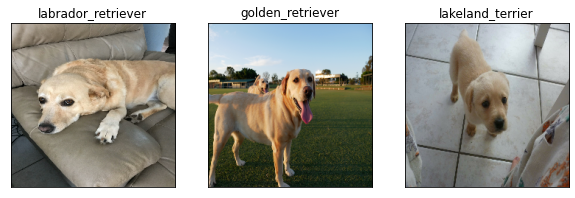

In [102]:
# Check Custom image predictions
plt.figure(figsize=(10, 10))
for i,image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)